# Graph Neural Network to solve Au=b

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.transforms import AddSelfLoops
from torch_geometric.data import Data, DataLoader

from scipy.sparse import coo_matrix, csr_matrix
from torch_sparse import coalesce, SparseTensor
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

C:\Users\soha9\anaconda3\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load data

A:   m x n  

b:   n x 1

x:   m x 1

In [3]:
#Load the data
A_matrix_path = "data/A_ex9.txt"
A_info = np.loadtxt(A_matrix_path)
m, n = A_info.shape

# Load u
# u_vector_path = "data/u_ex9.txt"
# u = np.loadtxt(u_vector_path)

# Extract the row, column, and value arrays from the data
row_A = A_info[:, 0].astype(int)
col_A = A_info[:, 1].astype(int)
val_A = A_info[:, 2]

# Create the sparse matrix using COO format
A_mfem = coo_matrix((val_A, (row_A, col_A)))

print('A shape: ',A_mfem.shape)

A shape:  (36865, 36865)


## Convert A from sparse to dense matrix

In [4]:
# Convert the sparse matrix into a dense matrix and replace non-zero elements with 1
dense_A_numpy = np.array(A_mfem.todense())
adj_matrix_numpy = np.where(dense_A_numpy > 0, 1, 0)
print(adj_matrix_numpy.shape)

(36865, 36865)


## Convert numpy arrays to tensors

In [5]:
A = torch.tensor(dense_A_numpy, dtype=torch.float)
adj_matrix = torch.tensor(adj_matrix_numpy, dtype=torch.float)
num_nodes = A.shape[0]

print('Number of nodes: ', num_nodes)
print('A shape: ', A.shape)
print('Adjacency matrix shape: ', adj_matrix.shape)

Number of nodes:  36865
A shape:  torch.Size([36865, 36865])
Adjacency matrix shape:  torch.Size([36865, 36865])


## Form u and b

In [6]:
u = torch.rand([num_nodes,1],dtype=torch.float)
b = torch.mm(A,u)

# A = A.to(device)
# b = b.to(device)
# u = u.to(device)

print(b.shape)
print(u.shape)
print(A.shape)

torch.Size([36865, 1])
torch.Size([36865, 1])
torch.Size([36865, 36865])


In [7]:
A

tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  8.8577e-06,  3.3011e-06,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  3.3011e-06,  4.4289e-05,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  4.4287e-05,
          7.3828e-06, -3.3014e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.3796e-06,
          4.4287e-05,  3.3021e-06],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -3.3005e-06,
          3.2999e-06,  8.8583e-06]])

In [8]:
u

tensor([[0.1145],
        [0.9684],
        [0.8208],
        ...,
        [0.5191],
        [0.7002],
        [0.5013]])

In [9]:
b

tensor([[0.0000e+00],
        [1.2807e-05],
        [5.8830e-05],
        ...,
        [2.6729e-05],
        [3.7688e-05],
        [9.2794e-06]])

In [10]:
# num_nodes = 50
# A = torch.rand((num_nodes, num_nodes))
# b = torch.rand((num_nodes, 1))
# x = b.clone()

# edge_index = torch.nonzero(A)
# edge_attr = A[edge_index[:,0], edge_index[:,1]]

#data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr, num_nodes=A.shape[0])

## Edge Index

In graph neural networks, edge_index is a commonly used term that refers to a matrix or tensor that represents the edges of a graph. It is a two-dimensional matrix with two rows, where each column represents an edge of the graph. The first row of the matrix contains the index of the source nodes of each edge, while the second row contains the index of the destination nodes.

For example, let's say we have a simple undirected graph with 4 nodes and 3 edges, where the edges are (0,1), (1,2), and (2,3). We can represent this graph using the following edge_index matrix:

```
edge_index = [
  [0, 1, 1, 2],
  [1, 0, 2, 3]
]
```
Here, the first row of edge_index represents the source nodes of each edge, and the second row represents the destination nodes. For example, the first edge (0,1) has source node 0 and destination node 1.

The edge_index matrix is typically used in conjunction with node feature matrices to define the input to a graph neural network. The node feature matrix contains features for each node in the graph, while the edge_index matrix describes the edges that connect the nodes. By combining these two matrices, a graph neural network can learn to operate on the graph structure and its associated features.

## Edge Weights

In graph neural networks, edge_weights are values associated with the edges of a graph, which can be used to represent the strength, importance or similarity between connected nodes. edge_weights can be used in a variety of ways, such as during message passing, graph convolutions or pooling operations.

edge_weights can be represented as a tensor or an array, with one value per edge. If the edges are unweighted, i.e., all edges are equally important, then the edge_weights can be represented as an array of ones. However, if the edges have different weights, then the edge_weights can be assigned accordingly.

In [11]:
# Create edge_index
mask = A != 0  # Get a boolean mask of non-zero elements in A
rows, cols = mask.nonzero(as_tuple=True)  # Get the row and column indices of non-zero elements
edge_index = torch.stack([rows, cols], dim=0)

# Create edge_weights
edge_weights = A[mask]

# Optionally add self-loops to the graph
#edge_index, edge_weights = torch.nn.utils.clip_grad.clip_grad_norm_(edge_index, edge_weights)

In [12]:
print('====== Edge Index =====')
print('edge_index shape: ',edge_index.shape)
print(edge_index)
print('====== Edge Weights =====')
print('edge_weights shape: ',edge_weights.shape)
print(edge_weights)

====== Edge Index =====
edge_index shape:  torch.Size([2, 662016])
tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]])
====== Edge Weights =====
edge_weights shape:  torch.Size([662016])
tensor([ 8.8577e-06,  3.3011e-06, -3.3011e-06,  ..., -3.3005e-06,
         3.2999e-06,  8.8583e-06])


## Actual Solution

In [13]:
# # Load u
# u_vector_path = "data/u_ex9.txt"
# u = np.loadtxt(u_vector_path)
# u.shape

## Create data object for input to GNN

The Data object has the following attributes:

- **'x'**: a tensor of node features with shape **'[36865, 1]'**. This means there are 36865 nodes in the graph, each with 1 feature.
- **'edge_index'**: a tensor of shape **'[2, 662016]'** representing the edge index of the graph. The first row contains the source nodes and the second row contains the destination nodes. There are 662016 edges in the graph.

- **'edge_attr'**: a tensor of edge weights with shape **'[662016]'**. This means there is one weight for each edge in the graph.

- **'num_nodes'**: an integer value of **36865** representing the total number of nodes in the graph.

In [14]:
# Create a Data object from edge_index, edge_weights, and node features
data = Data(x=b, edge_index=edge_index, edge_attr=edge_weights, num_nodes=num_nodes, y=u)
data = data.to(device)

# Print the Data object
print(data)

Data(x=[36865, 1], edge_index=[2, 662016], edge_attr=[662016], y=[36865, 1], num_nodes=36865)


## Graph Neural Network model

The given model is a graph convolutional network (GCN) that consists of 4 graph convolutional layers.

- First layer, the model takes a feature vector of size 1 for each node and applies the GCNConv operation with 128 output channels. The output of this layer is then passed through a rectified linear unit (ReLU) activation function.

- Last layer applies the GCNConv operation with a single output channel, which is the predicted value for each node.

The model takes the input data **'x'** and **'edge_index'** and returns the predicted values for each node.

In [15]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 128)
        self.conv2 = GCNConv(128, 64)
        self.conv3 = GCNConv(64, 16)
        self.conv4 = GCNConv(16, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        return x

## Train Graph Convolutional Network

In [16]:
model = GCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Define the loss function
criterion = torch.nn.MSELoss()

# Define the training loop
def train(model, data, optimizer, criterion, device):
    model.train()

    # Move the data to the device
    data = data.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Compute the model output
    out = model(data.x, data.edge_index)

    # Compute the loss
    loss = criterion(out, data.y)

    # Backpropagate the gradients
    loss.backward()
    optimizer.step()

    return loss.item()

# Train the model
loss_list = []
for epoch in range(500):
    loss = train(model, data, optimizer, criterion, device)
    loss_list.append(loss)
    print('Epoch {}, Loss: {}'.format(epoch, loss))

Epoch 0, Loss: 0.33537524938583374
Epoch 1, Loss: 0.27730220556259155
Epoch 2, Loss: 0.2060781568288803
Epoch 3, Loss: 0.136366605758667
Epoch 4, Loss: 0.08871687203645706
Epoch 5, Loss: 0.10190088301897049
Epoch 6, Loss: 0.13906723260879517
Epoch 7, Loss: 0.13022533059120178
Epoch 8, Loss: 0.10483704507350922
Epoch 9, Loss: 0.08810605108737946
Epoch 10, Loss: 0.08434795588254929
Epoch 11, Loss: 0.0880516767501831
Epoch 12, Loss: 0.093403659760952
Epoch 13, Loss: 0.09726420044898987
Epoch 14, Loss: 0.09811922162771225
Epoch 15, Loss: 0.09646585583686829
Epoch 16, Loss: 0.09315722435712814
Epoch 17, Loss: 0.08927682042121887
Epoch 18, Loss: 0.08598757535219193
Epoch 19, Loss: 0.08430007845163345
Epoch 20, Loss: 0.08470754325389862
Epoch 21, Loss: 0.08665592968463898
Epoch 22, Loss: 0.0885467454791069
Epoch 23, Loss: 0.08907773345708847
Epoch 24, Loss: 0.0881400927901268
Epoch 25, Loss: 0.0864846408367157
Epoch 26, Loss: 0.08501105010509491
Epoch 27, Loss: 0.08425278216600418
Epoch 28, L

Epoch 232, Loss: 0.0840139240026474
Epoch 233, Loss: 0.08401315659284592
Epoch 234, Loss: 0.08401238918304443
Epoch 235, Loss: 0.08401162177324295
Epoch 236, Loss: 0.08401084691286087
Epoch 237, Loss: 0.08401007950305939
Epoch 238, Loss: 0.0840093120932579
Epoch 239, Loss: 0.08400852978229523
Epoch 240, Loss: 0.08400776237249374
Epoch 241, Loss: 0.08400699496269226
Epoch 242, Loss: 0.08400622010231018
Epoch 243, Loss: 0.0840054452419281
Epoch 244, Loss: 0.08400467038154602
Epoch 245, Loss: 0.08400389552116394
Epoch 246, Loss: 0.08400312066078186
Epoch 247, Loss: 0.08400234580039978
Epoch 248, Loss: 0.0840015634894371
Epoch 249, Loss: 0.08400078862905502
Epoch 250, Loss: 0.08400000631809235
Epoch 251, Loss: 0.08399923145771027
Epoch 252, Loss: 0.08399845659732819
Epoch 253, Loss: 0.08399767428636551
Epoch 254, Loss: 0.08399689197540283
Epoch 255, Loss: 0.08399612456560135
Epoch 256, Loss: 0.08399532735347748
Epoch 257, Loss: 0.0839945450425148
Epoch 258, Loss: 0.08399646729230881
Epoch 

Epoch 458, Loss: 0.08383676409721375
Epoch 459, Loss: 0.08383601158857346
Epoch 460, Loss: 0.08383525907993317
Epoch 461, Loss: 0.08383451402187347
Epoch 462, Loss: 0.08383376151323318
Epoch 463, Loss: 0.08383302390575409
Epoch 464, Loss: 0.0838322639465332
Epoch 465, Loss: 0.08383152633905411
Epoch 466, Loss: 0.08383077383041382
Epoch 467, Loss: 0.08383003622293472
Epoch 468, Loss: 0.08382928371429443
Epoch 469, Loss: 0.08382854610681534
Epoch 470, Loss: 0.08382780104875565
Epoch 471, Loss: 0.08382706344127655
Epoch 472, Loss: 0.08382631838321686
Epoch 473, Loss: 0.08382558077573776
Epoch 474, Loss: 0.08382483571767807
Epoch 475, Loss: 0.08382409065961838
Epoch 476, Loss: 0.08382335305213928
Epoch 477, Loss: 0.08382262289524078
Epoch 478, Loss: 0.08382188528776169
Epoch 479, Loss: 0.08382114768028259
Epoch 480, Loss: 0.0838204100728035
Epoch 481, Loss: 0.083819679915905
Epoch 482, Loss: 0.0838189423084259
Epoch 483, Loss: 0.08381820470094681
Epoch 484, Loss: 0.08381747454404831
Epoch 

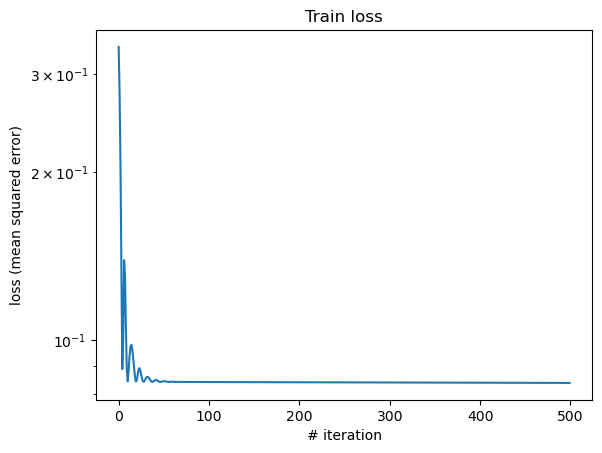

In [17]:
plt.figure(1)
plt.plot(loss_list, label = 'train loss')
plt.xlabel('# iteration')
plt.ylabel('loss (mean squared error)')
plt.yscale('log')
plt.title('Train loss')
plt.show()

In [18]:
data.edge_index

tensor([[    1,     1,     1,  ..., 36864, 36864, 36864],
        [    1,     2,     3,  ..., 36862, 36863, 36864]], device='cuda:0')

In [19]:
# Compute predicted u and residual error
model.eval()
predicted_u = model(data.x, data.edge_index)

In [20]:
predicted_u

tensor([[0.4989],
        [0.4916],
        [0.4916],
        ...,
        [0.4847],
        [0.4847],
        [0.5174]], device='cuda:0', grad_fn=<AddBackward0>)

In [21]:
u

tensor([[0.1145],
        [0.9684],
        [0.8208],
        ...,
        [0.5191],
        [0.7002],
        [0.5013]])

In [26]:
#residual_error = torch.sqrt(torch.sum(torch.square(torch.mm(A.to(device), predicted_u) - b.to(device))))